# Data At Scale: Capstone Project -- Milestone report
## Processing blight data in the city of Detroit, MI

## 1 Executive Summary

This project is part of the [Coursera Data Science at Scale Specialization](https://www.coursera.org/specializations/data-science) proposed by University of Washington and taught by Bill Howe. 
The objective of this assignment is to analyse various data source collected by the city of Detroit in order to build a model that could predict whether a building is likely to be blighted. The data was provided in  [datasci-capstone/get-the-data](https://www.coursera.org/learn/datasci-capstone/supplement/D44tm/get-the-data). 
Alternatively The data is available on the [Data At Scale Github repository: Capstone](https://github.com/uwescience/datasci_course_materials/tree/master/capstone/blight).

This notebook describe data selection and processing of the original files
The original data consists on:

* [detroit-blight-violations.csv](https://d3c33hcgiwev3.cloudfront.net/_97bd1c1e5df9537bb13398c9898deed7_detroit-blight-violations.csv?Expires=1525305600&Signature=eFD51fReW6lMTqFcCeDbQ1kgqi8sYAwZP7vMgVhsOOlv2QDrs61mX1tIBwdaqjaCVezWE30qjVPBzimiEafX2itPJiEPovHCzlOWMvnPe8x5RIeS-SbU0yPbG6~AHF7Cb0XITaoKlVmnMIAtiLstPqOOYfdhjUILu5~1dRNu8SE_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) Contianing a list of blight violations from which we constitute a list of buidlings
* [detroit-demolition-permits.tsv](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-demolition-permits.tsv?Expires=1525305600&Signature=f1GJGdUQshH1-g6GhDS-yUETWwkRis45gX9L85AGoXEuDHSzEhfdXWdo~tEbD~XHSXeRMNrgogVy-EYmO8t~7nfTnYt96LAcNxe73BTgvGdBDO~LdvA222Z9zs0sRxZAifSPbXnsW9jbxlDaqdnZNvc~zOkWxCN9aYQ2sBFujYQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) Contains a list of buildings for which demolition permits have been issues. We use that file to define the labels of our building, e.g. whether a building from the blight-violation dataset is blighted or not.
* [detroit-311.csv](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-311.csv?Expires=1525305600&Signature=al11Hk1qn7CACblYpryhkWbcoHm6dXQkRw~Mu7y6ONBEDy0rdQIjLHvwN8IqOsV6OFNOudDrinXBEz-m5Q9A2GZrvR0~bbnuZbsFd7y7eQTv~o-NazxOfLPwRUwViGCxSxcQhwBTiV0VjySP4fgExZwFX2xVwQqInjrKQYHs8iM_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)
* [detroit-crime.csv](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-crime.csv?Expires=1525305600&Signature=N0vg~4Jgqn6b-w-UEAQ3q0v3EbzgM9akDsHbn2o54WCdzh0Zzw~yJrcoBTHzkpBu0b3e4IiEFHUdKgVjryQRumLznIbaqEe146IC7FJqq8QqYWHVLcfquK9f3IXfCzoSNGeXGPWgT2l0BbzwAR6hxHeKxAxrXEajM7YWNwwIL7U_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)
* To which we added [Parcel_Points_Ownership.csv](https://data.detroitmi.gov/Property-Parcels/Parcel-Points-Ownership/dxgi-9s8s) made publically available by the city of Detroit. 

For the first 4 dataset, we build processed versions as
* *blight_demolition.csv* corresponding to a set of demolished buildings. We used the [Detroit Parcel Point API](https://data.detroitmi.gov/resource/snut-x2sy) to correct the gps coordinates
* *blignt_incidents_count.csv*, also we recaptured gps coordinates with [Detroit Parcel Point API](https://data.detroitmi.gov/resource/snut-x2sy) and with the incident count and amounts associated to blight violation per unique set of addresses
* *c311_incident_count.csv* corresponding to the number of 311 calls associated to unique sets of gps coordinates limited to the city area
* *crime_incident_count.csv* corresponding to the number of crimes reported per unique sets of gps coordinates limited to the city area

We also prepared a train set *train_set.csv* and a test set *test_set.csv* with respectivelly 9458 and 2410 uniques sets of gps coordinates with associated demolished and not demolished label. The instance of demolished buildings location taken from *blight_demolition.csv* with an equal number of non-demolished locations extracted from *Parcel_Points_Ownership.csv*

## 2 Preparation

### 2.1 Necessary modules

In [1]:
# use this for incorporating figure in the notebook
%matplotlib inline              
import matplotlib.pyplot as plt # for vizualisation
import os                       # file system utilities
import json                     # json library to export grid setup
import re                       # regular expression
import time                     # for mesuring CPU time
import pandas as pd             # data processing
from datetime import datetime   # for treating dates
import geopy.distance           # gps cooridnate convertion
from collections import Counter # usefull function

### 2.2 Listing input files

In [2]:
# Use this variable to define the path to the data
data_path = "Data"+os.sep
processed_path = "Processed"+os.sep
# Extrqct the list of files
listfiles = os.listdir(data_path)
# Build a function to remove the SHA ney
file_key = lambda strinp: re.sub("_[a-f0-9]{1,}_","",strinp)
# Build the file dictionnary
dic_inp = {}
for finp in listfiles:
    dic_inp[file_key(finp)]=data_path+finp
# clean up
del listfiles
for k,v in dic_inp.items():
    print k,": ",v

Parcel_Points_Ownership.csv :  Data/Parcel_Points_Ownership.csv
detroit-crime.csv :  Data/_dcebfb2135a2bf5a6392493bd61aba22_detroit-crime.csv
detroit-demolition-permits.tsv :  Data/_dcebfb2135a2bf5a6392493bd61aba22_detroit-demolition-permits.tsv
detroit-311.csv :  Data/_dcebfb2135a2bf5a6392493bd61aba22_detroit-311.csv
detroit-blight-violations.csv :  Data/_97bd1c1e5df9537bb13398c9898deed7_detroit-blight-violations.csv


## 3 Processing data

### 3.1 Defining city boundaries

We set the city boundaries to be within the following range
* Latitude between 42.25 and 42.45
* Longitude between -83.30 and -82.90

In [3]:
# Set city boundariies in lngitudes and lattitude coordinate
gps_box = {
    "lat":[42.25,42.45],
    "long":[-83.30,-82.90]
}
# Mesure carteian size
gps_box["Dx"] = geopy.distance.vincenty(gps_box["long"][1],gps_box["long"][0]).m
gps_box["Dy"] = geopy.distance.vincenty(gps_box["lat"][1],gps_box["lat"][0]).m

We further build an helper function to check for select valid gps coordinate within this area

In [4]:
def within_area(gps_coords):
    """
    read series with lat and long fields
    returns True if coordinates are within box area
    retruns False otherwise
    """
    if any(gps_coords[["long","lat"]].isnull()):
        return False
    if gps_coords["long"] < gps_box["long"][0]:
        return False
    elif gps_coords["long"] > gps_box["long"][1]:
        return False
    if gps_coords["lat"] < gps_box["lat"][0]:
        return False
    elif gps_coords["lat"] > gps_box["lat"][1]:
        return False
    return True

### 3.2 Demolition dataset

In [5]:
dem = pd.read_csv(dic_inp["detroit-demolition-permits.tsv"],sep="\t")
col_dem = {
    "SITE_ADDRESS":"address",
    "PERMIT_ISSUED":"date",
    "BLD_PERMIT_TYPE":"type"
}
dem = dem.drop_duplicates(subset="PERMIT_NO")[list(col_dem.keys())].rename(columns=col_dem)
# this line is commented so as not to overwrite the processed file.
# This should be uncommented to restart form scratch
## dem.to_csv(processed_path+"blight_demolition.csv",index=False)

We then use the API [Detroit city API](https://data.detroitmi.gov/resource/snut-x2sy) to find genuine gps coordinates for all addresses in this dataset. 
The code in available as *py3_scripts/spider_dem_gps.py*

After this processing we obtain a file following this schema
* **address**: address of the demolition site
* **date**: date of issue of the demolition permit m/d/y
* **type**: Takes value "DISM" or "Dismantle"
* **long**: longitude 
* **lat**: latitude

In [6]:
dem = pd.read_csv(processed_path+"blight_demolition.csv")
dem.head()

,address,date,type,lat,long
0,4331 BARHAM,8/28/15,Dismantle,42.394008,-82.947587
1,9707 BESSEMORE,8/28/15,Dismantle,42.395303,-83.005067
2,5315 BERKSHIRE,8/28/15,Dismantle,42.403678,-82.946976
3,16670 BRINGARD DR,8/28/15,Dismantle,42.446371,-82.947196
4,1454 BEATRICE,8/28/15,Dismantle,42.277026,-83.147751


As we explore the type in relation with the date.

In [7]:
# convert date from string to date
dem["date"] = dem.apply(lambda line: datetime.strptime(str(line['date']),"%m/%d/%y").date(),axis=1)

In [8]:
dem_in = dem.apply(within_area,axis=1)
dem.loc[dem_in,["date","type"]].groupby("type").agg(["min","max","count"])

date                  
                  min         max count
type                                   
DISM       2010-05-20  2015-04-15  4729
Dismantle  2015-06-12  2015-08-28  1205

We find that type "Dismantle" correspond to building schedule for demolition starting june 2015. 
Within the area, we find 4729 buldings before june 2015 and 1205 from june 2015

### 3.3 Blight violation dataset

In [9]:
# Read the blight violation file to avoid a warning we read everything as strings
dblight = pd.read_csv(dic_inp["detroit-blight-violations.csv"],dtype=str)
col_fees = ['AdminFee','LateFee','StateFee','CleanUpCost','JudgmentAmt']
col_sel = ["ViolationStreetNumber","ViolationStreetName","PaymentStatus"]
# as previously we remove all duplicates by ticketId keeping the last entry
dblight = dblight.drop_duplicates(subset="TicketID",keep='last')[col_sel+col_fees]
dblight.head()

,ViolationStreetNumber,ViolationStreetName,PaymentStatus,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt
0,2566,GRAND BLVD,PAID IN FULL,$20.00,$150.00,$10.00,$0.00,$1680.00
1,19014,ASHTON,NO PAYMENT APPLIED,$20.00,$10.00,$10.00,$0.00,$140.00
2,18735,STAHELIN,PAID IN FULL,$20.00,$10.00,$10.00,$0.00,$140.00
3,20125,MONICA,NO PAYMENT APPLIED,$20.00,$10.00,$10.00,$0.00,$140.00
4,17397,PRAIRIE,PAID IN FULL,$20.00,$10.00,$10.00,$0.00,$140.00


The first task consists on 
* cleaning the data by converting the amount written as strings into flaots.
* associating the ammount to the actual payment status as a new column

In [10]:
status = {
    "PAID IN FULL":"blight_paid",
    "PARTIAL PAYMENT MADE":"blight_partial",
    "NO PAYMENT APPLIED":"blight_notapplied",
    "NO PAYMENT ON RECORD":"blight_nopaid"
}
def read_amount(stramount):
    """
    Read a string corresponding to an ammount in USD
    returns a float
    """
    amlist = re.findall("\$*([0-9]+\.{,1}[0-9]{0,2})",str(stramount))
    if len(amlist) ==0:
        return 0.
    else:
        return float(amlist[0])
def grab_payment(line):
    """
    takes a row of the blight dataset as entry retrun a series with
    blight_nopaid: the total fee with a NO PAYMENT ON RECORD status
    blight_paid: the total fee with a PAID IN FULL status
    blight_partial: the total fee with a PARTIAL PAYMENT MADE status
    blight_notapplied: the total fee with a NO PAYMENT APPLIED status
    """
    fees = pd.Series()
    for val in status.values():
        fees[val]=0.
    totamount = 0.
    for fee_entry in  col_fees:
        totamount += read_amount(line[fee_entry])
    fees[status[line["PaymentStatus"]]] = totamount
    return fees

In [11]:
payment = dblight.apply(grab_payment,axis=1)
dblight = dblight[["ViolationStreetNumber","ViolationStreetName"]].merge(payment,left_index=True,right_index=True)
dblight["blight_inc"] = 1

Multiple blight incidents may be associated to the same address. For this reason we have to aggregate them by street number and street name. 

In [12]:
# First process the address to remove abbreviations
dblight["ViolationStreetName"] = dblight["ViolationStreetName"].apply(
     lambda x: re.sub("( ST\.?| DR\.?| RD\.?| BLVD\.?)","",x).strip()
)
# Run the aggregation
blight_gb = dblight.groupby(["ViolationStreetNumber","ViolationStreetName"],as_index=False).sum()
print "Before aggregation", len(dblight),"rows. After aggregation",len(blight_gb),"rows"

Before aggregation 301567 rows. After aggregation 110699 rows


In [13]:
# add longitude and latitude features initialized with nan
blight_gb["long"] = pd.np.nan
blight_gb["lat"] = pd.np.nan
# this line is commented so as not to overwrite the processed file.
# This should be uncommented to restart form scratch
## blight_gb.to_csv(processed_path+"blight_incident_count.csv",index=False)

We then use the API [Detroit city API](https://data.detroitmi.gov/resource/snut-x2sy) to search for genuine gps coordinates for all addresses in this dataset. 
The code in available as *py3_scripts/spider_blight_gps.py*. We note that coordinates of unidentified addresses are set to (0.,0.).

After this processing we obtain a file following this schema
* **ViolationStreetNumber**: Street number extracted from the source file, instance with negative or missing value were removed
* **ViolationStreetName**: Street number extracted from the source file, street abbreviations were removed
* **address**: Vialtion address concatenated from  ViolationStreetNumber and ViolationStreetName
* **blight_inc**: number of blight violations associated to the adress 	
* **blight_paid**: total amount in USD assocated with the original *PAID IN FULL* label
* **blight_partial**: total amount in USD associated with the original *PARTIAL PAYMENT MADE* label
* **blight_nopaid**: total amount in USD associated with the original *NO PAYMENT ON RECORD* label
* **blight_notapplied**: total amount in USD associated with the original *NO PAYMENT APPLIED* label
* **long**: longitude 
* **lat**: latitude

In [14]:
blight_inc = pd.read_csv(processed_path+"blight_incident_count.csv")
# no longer necessary but it is a good idea to select only instance within the area and overwrite the file
## blight_in = blight_inc.apply(within_area,axis=1)
## blight_inc.loc[blight_in].to_csv(processed_path+"blight_incident_count.csv",index=False)
blight_inc.head()

,ViolationStreetNumber,ViolationStreetName,blight_nopaid,blight_paid,blight_partial,blight_notapplied,blight_inc,address,long,lat
0,1,GRISWOLD,0.0,360.0,0.0,360.0,2,1 GRISWOLD,-83.045981,42.328438
1,1,LAFAYETTE PLAISA,0.0,0.0,0.0,6360.0,6,1 LAFAYETTE PLAISA,-83.037094,42.340398
2,10,ATKINSON,0.0,1380.0,0.0,0.0,3,10 ATKINSON,-83.082933,42.383841
3,10,WITHERELL,0.0,0.0,0.0,16410.0,15,10 WITHERELL,-83.049734,42.335954
4,100,BLAINE,0.0,0.0,0.0,180.0,1,100 BLAINE,-83.081510,42.379181


### 3.4 311 calls dataset

In [15]:
# Read the blight violation file to avoid a warning we read everything as strings
d311 = pd.read_csv(dic_inp["detroit-311.csv"], quotechar='"',converters={"lng":float,"lat":float})
# remove duplicate tickets
d311.drop_duplicates(subset="ticket_id")
# rename lng as long
d311.rename(columns={"lng":"long"},inplace=True)

In [16]:
d311_in = d311.apply(within_area,axis=1)
d311["inc_311"] = 1
d311_gb = d311.loc[d311_in,["long","lat","inc_311"]].groupby(["long","lat"],as_index=False).sum()

In [17]:
d311_gb.head()

,long,lat,inc_311
0,-83.287138,42.437345,1
1,-83.287061,42.422309,1
2,-83.286695,42.438868,1
3,-83.286604,42.412567,1
4,-83.286597,42.412409,1


After this processing we obtain a file following this schema
* **long**: longitude associated to the complaint
* **lat**: latitude associated to the complaint
* **inc_311**: number of incidents reported through 311 call for these set of coordinates

In [18]:
d311_gb.to_csv(processed_path+"c311_incident_count.csv")

### 3.5 Crime dataset

In [19]:
dcrime = pd.read_csv(dic_inp["detroit-crime.csv"])
dcrime.rename(columns = {"LON":"long","LAT":"lat"},inplace=True)

/Users/dtweed/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
dcrime.head()

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,long,lat,LOCATION
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,06/03/2015 12:00:00 AM,2,1007.0,10.0,City Council District 5,PETOSKEY-OTSEGO,5334.0,09100 PETOSKEY,-83.1221,42.3678,"PETOSKEY\n09100\n(42.3676, -83.1219)"
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,03/01/2015 12:00:00 AM,9,608.0,6.0,City Council District 7,GRANDALE,5452.0,00 PLYMOUTH AND MANSFIELD,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\n(42.3725, -83.2033)"
2,11207,1910955,1502080223.1,STOLEN VEHICLE,VEHICLE THEFT,24001.0,02/08/2015 12:00:00 AM,18,1105.0,11.0,City Council District 3,OUTER DRIVE VAN DYKE,5051.0,00 E 7 MILE VAN DYKE,-83.0241,42.4338,"00 E 7 MILE VAN DYKE\n(42.4339, -83.0241)"
3,116589,2018186,1511090188.1,WEAPONS OFFENSES,WEAPONS OFFENSE (OTHER),52003.0,11/09/2015 12:00:00 AM,12,210.0,2.0,City Council District 6,TIREMAN,NaN,06600 BARTON,-83.1381,42.3496,"BARTON\n06600\n(42.3494, -83.1379)"
4,85790,1986862,1508239803.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,08/14/2015 12:00:00 AM,7,309.0,3.0,City Council District 6,WEST CANFIELD,5204.0,00900 W WILLIS,-83.0692,42.3481,"W WILLIS\n00900\n(42.3481, -83.0693)"


In [21]:
dcrime_in = dcrime.apply(within_area,axis=1)
print "Number of incidents within area",sum(dcrime_in),"total",len(dcrime_in) 

Number of incidents within area 119363 total 119931


Since the same case can correspond to multiple offence, it is usefull to aggregate the crime incidents by locations. 

In [22]:
dcrime["crime_inc"] = 1
dcrime_gb = dcrime.loc[dcrime_in,["long","lat","crime_inc"]].groupby(["long","lat"],as_index=False).sum()

In [23]:
dcrime_gb.head()

,long,lat,crime_inc
0,-83.2975,42.3842,1
1,-83.2968,42.2954,1
2,-83.2966,42.3986,1
3,-83.2959,42.3993,1
4,-83.2931,42.2654,1


After this processing we obtain a file following this schema
* **long**: longitude associated to the complaint
* **lat**: latitude associated to the complaint
* **crime_inc**: number of incidents reported through 311 call for these set of coordinates

In [24]:
dcrime_gb.to_csv(processed_path+"crime_incident_count.csv")

### 3.6 Parcels dataset 

In [25]:
parcels = pd.read_csv(dic_inp["Parcel_Points_Ownership.csv"])
parcel_col = {
    "Longitude":"long",
    "Latitude":"lat"
}
parcels = parcels[parcel_col.keys()].rename(columns=parcel_col)

/Users/dtweed/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 4 Building a train and test set

### 4.1 Defining a grid

This helper function define a grid with some specific resolutions

In [26]:
def prep_grid(dg):
    """
    Take a dstance in meter as input
    Read the gps_box 
    Returns a dictionnary defining the grid
    """
    # we use differents scale for lattitude and longitudes 
    dlat = (gps_box["lat"][1]-gps_box["lat"][0])*dg/gps_box["Dy"]
    dlong = (gps_box["long"][1]-gps_box["long"][0])*dg/gps_box["Dx"]
    nx = int(gps_box["Dx"]/dg) + 1
    ny = int(gps_box["Dy"]/dg) + 1
    return {"dlat":dlat,"dlong":dlong,"nx":nx,"ny":ny,"scale":dg}

We use this function to define the grid prior to building a new function that will associate gird index to any set of gps coordinate within the area.

In [27]:
# Define the grid
scal = 60
gdef = prep_grid(scal)
def build_grid_index(line):
    """
    Takes a row containing fileds "long" and "lat" as input
    Return a grid index corresponding to the gird defined as gdef
    Note: row must have been selected with the select_within_area method
    """
    ix = int((line["long"]-gps_box["long"][0])/gdef["dlong"])
    iy = int((line["lat"]-gps_box["lat"][0])/gdef["dlat"])
    return iy*gdef["nx"] + ix

For later use we save these information in a json file.

In [28]:
#save grid info as a json
gf = open(processed_path+"grid.json","w")
json.dump({"box":gps_box,"grid":gdef},gf)
gf.close()

### 4.2 Combining parcel adn demolition datasets

* We start by selected amoung the parcel data those within the area
* We associate a grid index to each rom
* We proceed also associate a grid index to each demolition row
* we then merge both set on the grid index

In [30]:
parcel_in = parcels.apply(within_area,axis=1)
parcels = parcels.loc[parcel_in]
print "Number of parcels wuthin area",sum(parcel_in),"out of",len(parcel_in)
del parcel_ins
parcels["grid"] = parcels.apply(build_grid_index,axis=1)

In [33]:
dem_in = dem.apply(within_area,axis=1)
dem = dem.loc[dem_in]
dem["grid"]= dem.apply(build_grid_index,axis=1)

/Users/dtweed/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We first have a look at the distribution of the number of buuldings per grid cell in both set.
We expect that our grid will not be precise enough to isolate every buildings.

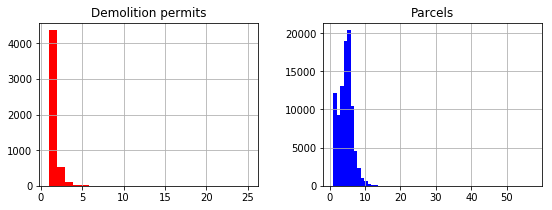

In [35]:
dem_count = Counter(dem["grid"])
par_count = Counter(parcels["grid"])
dem_count = pd.DataFrame.from_dict(dem_count,orient='index').rename(columns={0:"demolition_permit"})
par_count = pd.DataFrame.from_dict(par_count,orient='index').rename(columns={0:"parcels"})
# plot a figure
fig = plt.figure(figsize=(9,3))
axl  = plt.subplot(121)
hdem = dem_count.hist(ax=axl,color="red",bins=max(dem_count["demolition_permit"]))
ltit = plt.title("Demolition permits")
axr  = plt.subplot(122)
hparcels = par_count.hist(ax=axr,color="blue",bins=max(par_count["parcels"]))
rtit = plt.title("Parcels")

Indeed for the demolition dataset the overlap is not extreme, but in the case of the parcel dataset we obtain a lot of aoverlap. We are reducing the data by selecting only one instance of parcel per grid cell

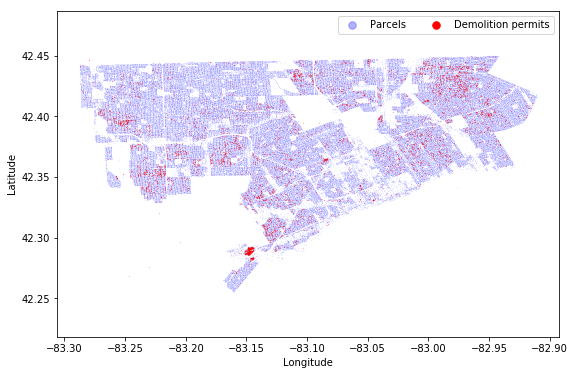

In [36]:
parcel_grid = parcels.drop_duplicates("grid")
fig = plt.figure(figsize=(9,6))
ax  = plt.subplot(111)
axp = parcel_grid.plot.scatter(x="long",y="lat",s=0.01,color="blue",alpha=0.3,ax=ax,label="Parcels")
axd = dem.plot.scatter(x="long",y="lat",s=0.01,color="red",ax=ax,label="Demolition permits")
xl = plt.xlim(gps_box["long"])
yl = plt.ylim(gps_box["lat"])
xlab = plt.xlabel("Longitude")
ylab = plt.ylabel("Latitude")
xy = plt.axis('equal')
legend = plt.legend(markerscale=75,ncol=2)

We now merge the two datasets with an outer join. So that:
* Any parcel found the demolition dataset will have a type set to either *DISM* or *Dismantle*
* Any parcel not fount in the demolition dataset, will have a missing values associated to the type
* Any demolition instance not found in the parcel dataset with have missing valaues for *lat* and *long*

In [40]:
parcel_dem = parcel_grid.merge(dem,on="grid",suffixes=("","_dem"),how="outer")
type_count = Counter(parcel_dem["type"])
pd.DataFrame.from_dict(type_count,orient="index").rename(columns={0:"nb_rows"})

,nb_rows
NaN,88162
Dismantle,1205
DISM,4729


### 4.3 Building the training and testing datasets

We are going to select the buildings with type *Dismantle* to be part of the test set and those with type *DISM* to be part of the training set.
For each set we are going to sample an equivalent number of buildings with missing type

In [41]:
pd.np.random.seed(42)
available_index = parcel_dem.loc[parcel_dem["type"].isnull()].index
train_index = pd.np.random.choice(parcel_dem.loc[parcel_dem["type"].isnull()].index,type_count["DISM"],replace=False)
parcel_dem.loc[train_index,"type"] = "train"
test_index = pd.np.random.choice(parcel_dem.loc[parcel_dem["type"].isnull()].index,type_count["Dismantle"],replace=False)
parcel_dem.loc[test_index,"type"] = "test"
type_count = Counter(parcel_dem["type"])
pd.DataFrame.from_dict(type_count,orient="index").rename(columns={0:"nb_rows"})

,nb_rows
NaN,82228
test,1205
train,4729
Dismantle,1205
DISM,4729


We further create the *demolition* feature to mark building scheduled for demolition with 1 and building not scheduled for demolition with 0.

In [42]:
def label_demolition(line):
    if line["type"] == 'DISM' or line["type"] == 'Dismantle':
        return 1
    else:
        return 0
parcel_dem["demolition"] = parcel_dem.apply(label_demolition,axis=1)

We also search for missing gps coordinate, demolished build not associated to any parcel building. 

In [43]:
missing_gps = pd.np.logical_or(parcel_dem["lat"].isnull(),parcel_dem["long"].isnull())
parcel_dem.loc[missing_gps,"long"] = parcel_dem.loc[missing_gps,"long_dem"]
parcel_dem.loc[missing_gps,"lat"] = parcel_dem.loc[missing_gps,"lat_dem"]

We finally devide the dataframe into two, on training set and one testing set, using the type feature.
We make sure to shuffle the indexes so that categories are mixed. We only keep the gps coordinates and demolition labels.

In [44]:
train_index = parcel_dem.loc[pd.np.logical_or(parcel_dem["type"]=='DISM',parcel_dem["type"]=='train')].index
shuffle_train= pd.np.random.choice(train_index,len(train_index),replace=False)
test_index = parcel_dem.loc[pd.np.logical_or(parcel_dem["type"]=='Dismantle',parcel_dem["type"]=='test')].index
shuffle_test= pd.np.random.choice(test_index,len(test_index),replace=False)
training = parcel_dem.loc[shuffle_train,["long","lat","demolition"]]
testing = parcel_dem.loc[shuffle_test,["long","lat","demolition"]]

In [45]:
training.head(10)

,long,lat,demolition
78834,-82.978012,42.412112,0
59901,-82.992764,42.377932,1
30379,-83.286062,42.438711,0
78274,-83.132418,42.415267,0
52824,-83.147667,42.290693,1
55279,-83.023605,42.382146,1
37623,-83.193677,42.362924,0
4234,-82.987878,42.434166,1
12147,-83.162538,42.393675,0
69427,-83.162798,42.381663,0


In [46]:
testing.head(10)

,long,lat,demolition
93898,-82.977761,42.372243,0
93960,-82.949084,42.402957,1
43210,-83.002287,42.377617,0
18056,-83.171188,42.362799,1
33408,-82.974838,42.441437,1
54161,-82.962371,42.412907,0
18287,-83.176043,42.398750,0
65840,-82.960464,42.407284,0
8185,-83.168551,42.374576,1
62983,-82.983169,42.440327,1


We now save the data for later use.

In [47]:
training.to_csv(processed_path+"train_set.csv",index=False)
testing.to_csv(processed_path+"test_set.csv",index=False)

## 5 Conclusion

In this notebook we described how we apply data cleaning to the roiginal files provided for this Capstone project. 
We benefit from [Detroit API](https://data.detroitmi.gov/resource/snut-x2sy) to correct for inaccurate gps coordinates and removed bad addresses. We defined a area to emcompass the city in order to limit the rows to actual location in Detroit. We also applied grid method to define a building instance a 60m$\times$60m square ($\sim 200\times200$ feet).
We build two labeled datasets, a training set and a test set for machine learning purpose. For both these sets, additionnal feature are to be created using the processed set we generated in this notebook. 